### Introduction
The problem is to forecast the monthly milk production per cow in an agricultural environment.The dataset describes a time-series of milk production 9in pounds per cow) over 13 years (1962-1974), and there are 156 observations. We used the first 80% of the observations for training and testing various models while holding back the remaining observations for validating the final model

### Section1. Define Problem and Acquire Data

#### 1.a) Load Libraries

In [2]:
#!pip install pmdarima

     |████████████████████████████████| 1.4 MB 4.3 MB/s 
     |████████████████████████████████| 9.8 MB 39.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [93]:
# Set the warning message filter
import warnings
warnings.filterwarnings("ignore" , category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import smtplib
import pmdarima as pm
from datetime import datetime
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

#### 1.b) Set up the controlling parameter and finctions

In [95]:
# Create the random seed number for reproducible results
seedNum = 888
# Set uo the number of cpu cores available for multi-thread processing 
n_jobs = -1

# Set up the verbose flag to print detailed message for debugging (setting true will activate!)
verbose = False

#### 1.c) Acquire and Load the data

Since the dataset is not current, this means we cannot easily collect data to validate the model. Therefore, we will withhold a portion of the data towards the end from analysis and model selection. This very segment of data will be used to validate the model.

In [96]:
startTimeScript = datetime.now()

In [97]:
# load the dataset and necesssary datastructure
time_series = pd.read_csv("milk.csv", index_col='Date', parse_dates=True)
#time_series.columns = time_series.rename(columns={'Date':'idx',
#                                                  'Milk':'values'})
time_series.head()

,Milk
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [98]:
time_series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Milk    168 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB


In [144]:
time_series.isnull().sum()

Milk    0
dtype: int64

In [138]:
target_col = time_series.columns[0]
#target_col = 'values'
lower_bound = 'lower ' + target_col
upper_bound = 'upper ' + target_col
print("The target column of the time series is: ", target_col)
print("The forcast boundary columns are:", lower_bound, '&', upper_bound)

The target column of the time series is:  Milk
The forcast boundary columns are: lower Milk & upper Milk


In [100]:
time_series.head()

,Milk
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [101]:
time_series.tail(10)

,Milk
Date,
1975-03-01,892
1975-04-01,903
1975-05-01,966
1975-06-01,937
1975-07-01,896
1975-08-01,858
1975-09-01,817
1975-10-01,827
1975-11-01,797


### Summary statistics of time series

In [102]:
print(time_series.describe())

             Milk
count  168.000000
mean   754.708333
std    102.204524
min    553.000000
25%    677.750000
50%    761.000000
75%    824.500000
max    969.000000


#### 2.b) Line Plot of the Time Series Data

A line plot of a time series can provide a lot of insight into the problem.

* Whether the tren appears to be level around the mean
* Whether there appear to be any obvious outliers

The ADF results should show that the test statistic value is smaller than the critical value at 5% if the time series is stationary. This suggests that we can reject the null hypothesis (i.e. a low probability that the result is a statistical fluke).

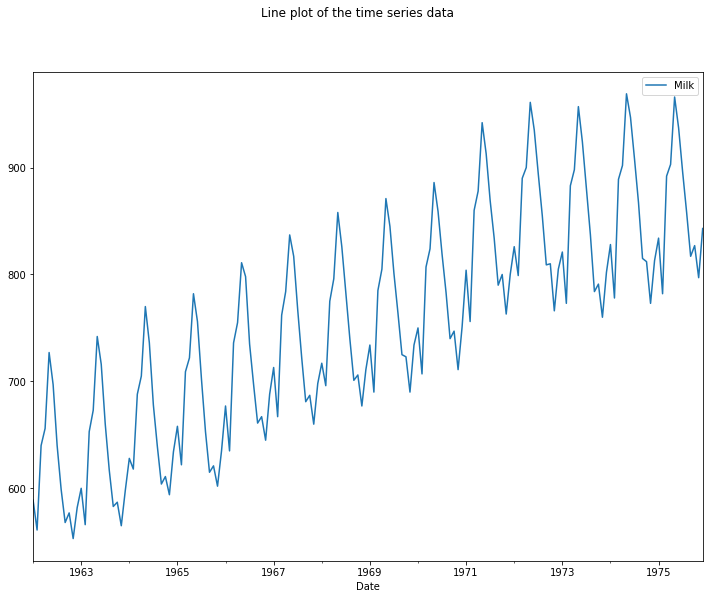

In [103]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle("Line plot of the time series data")
time_series.plot(ax=ax)
plt.show()

#### 2.c) Histogram and Density plots of the time series data

Reviewing the density of observations can provide further insight into the structure of the data. Some observations from plots can include:
* Whether the distribution is Gaussian
* Whether the distribution has long tail and may suggest the need for data transformation

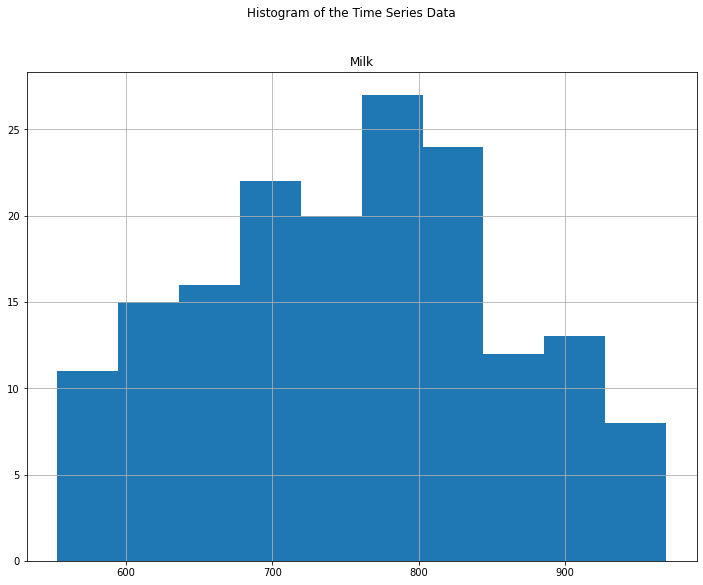

In [104]:
# Hist plots of the time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Histogram of the Time Series Data')
time_series.hist(ax=ax)
plt.show()

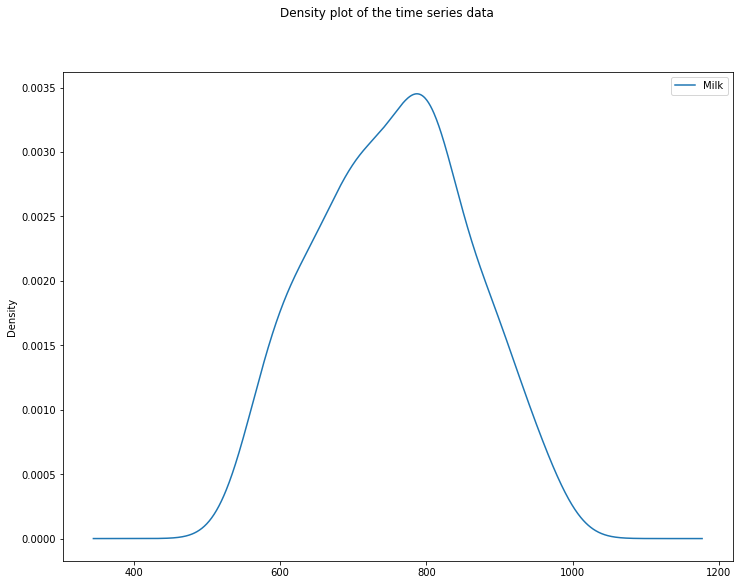

In [105]:
# Density plot of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle("Density plot of the time series data")
time_series.plot(kind='kde', ax=ax)
plt.show()

#### 2.d) Box and Whisker Plots of the Time Series Data

We can group or aggregation the data and get a better idea of the spread of observations.Some observations from reviewing the plot can include:

* Whether the median values for each grouping shows any significant trend.
* Whether the spread, or middle 50% of the data, shows any significant varibaility.
* Whether there are outliers in some grouping

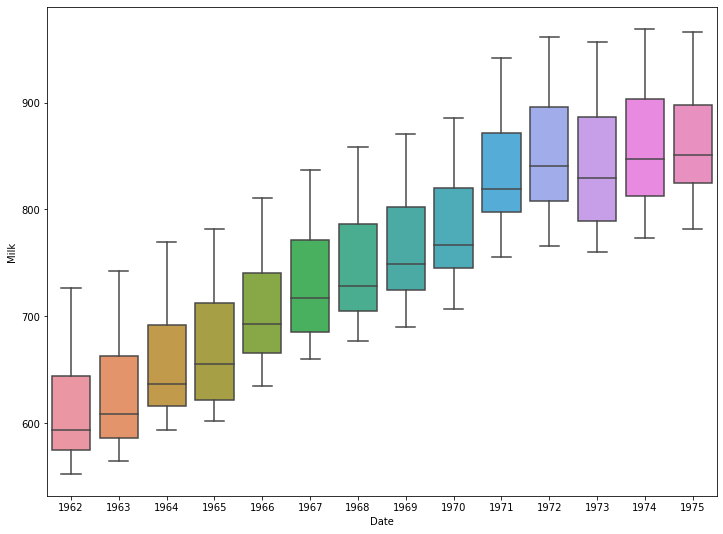

In [106]:
# boxplot of time series
fig, ax = plt.subplots(figsize=(12, 9))
squeezed = time_series.squeeze()
sns.boxplot(squeezed.index.year, squeezed, ax=ax)

#### 3.a) Data Transformation

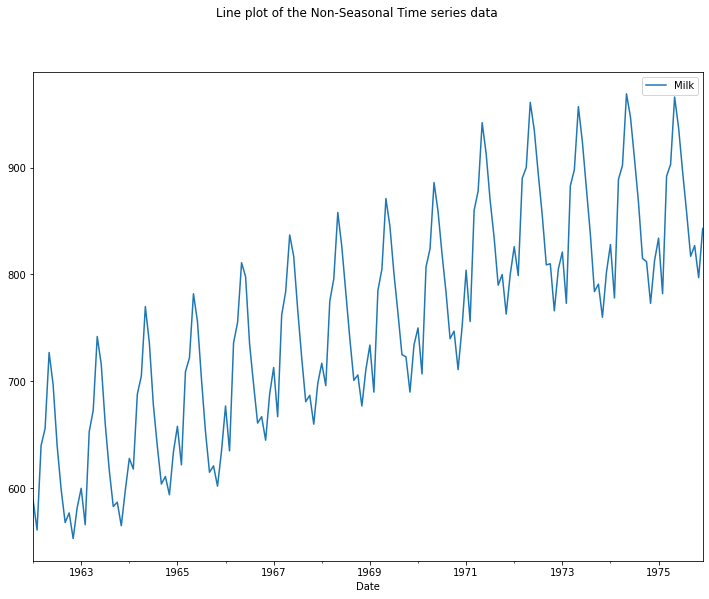

In [107]:
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle("Line plot of the Non-Seasonal Time series data")
time_series.plot(ax=ax)
plt.show()

#### Section 3.b) Test for stationarity

In [108]:
#Check for stationary
target_col = time_series.columns[0]
result = adfuller(time_series[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.303812
p-value: 0.627427
	1%: -3.474
	5%: -2.880
	10%: -2.577


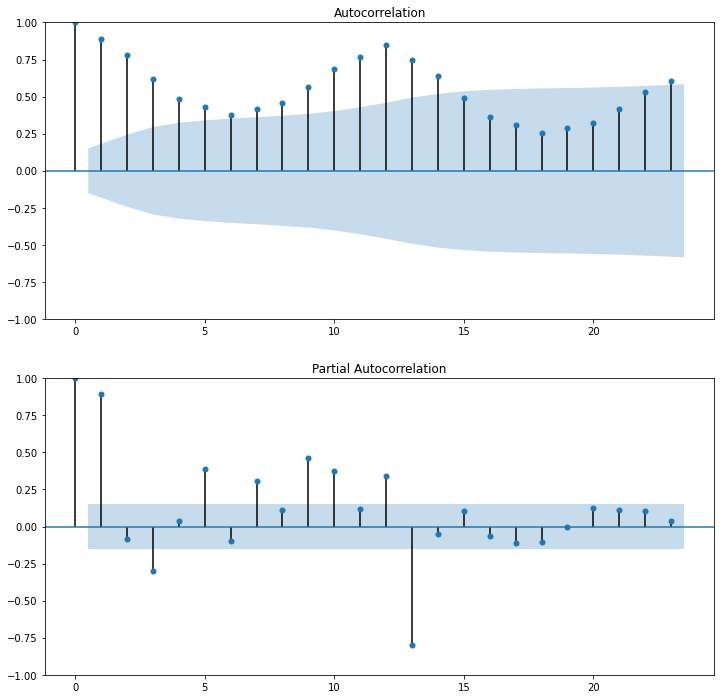

In [109]:
#ACF and PACF plots of the time series data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(time_series, ax=ax1)
plot_pacf(time_series, ax=ax2)
plt.show()

#### 3.c)Test for Stationarity of Non-Seasonal Time series data

Ocassionaly a time series may look non-stationary on the first look.We can make it stationary by differencing the series and using a statistical test to confirm that the differenced result is stationary.Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure

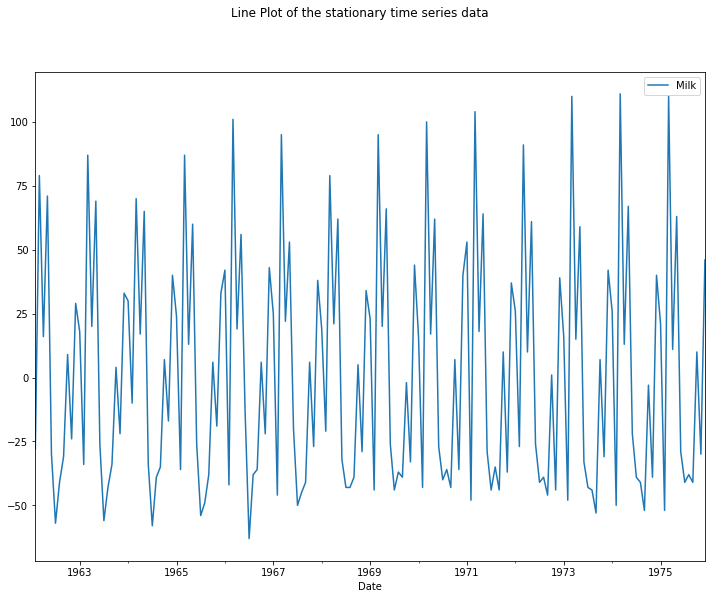

In [110]:
# Create a differenced series
stationary_ns = time_series.diff().dropna()

#plot the difference data
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the stationary time series data')
stationary_ns.plot(ax=ax)
plt.show()

In [111]:
# Check for stationarity
result = adfuller(stationary_ns[target_col])
print('ADF Statisitics: %f' % result[0])
print('p-value: %f' %result[1])
print("Critical Test Statistic Values:")
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statisitics: -3.054996
p-value: 0.030068
Critical Test Statistic Values:
	1%: -3.474
	5%: -2.881
	10%: -2.577


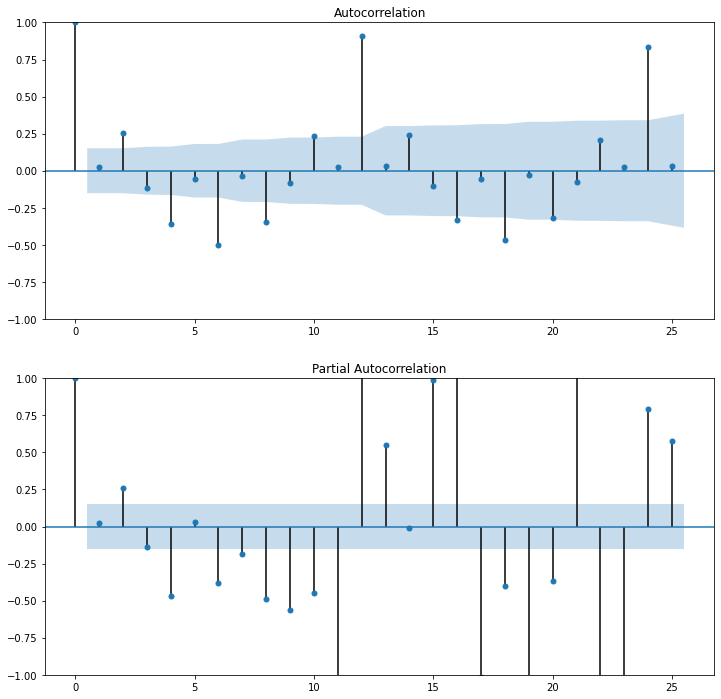

In [112]:
# ACF and PACF plots of the stationary time series
lags = 25
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(stationary_ns, lags=lags, ax=ax1)
plot_pacf(stationary_ns, lags=lags, ax=ax2)
plt.show()

#### 3.d) Seasonal Decomposition for seasonal time series data

In [113]:
# Set the initial seasonal frequency parameter
seasonal_freq = 12

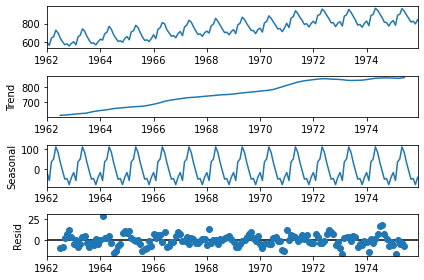

In [114]:
# Perform seasonal decomposition to observe the seasonal frequency
decomp_results = seasonal_decompose(time_series, period=seasonal_freq)
decomp_results.plot()
plt.show()

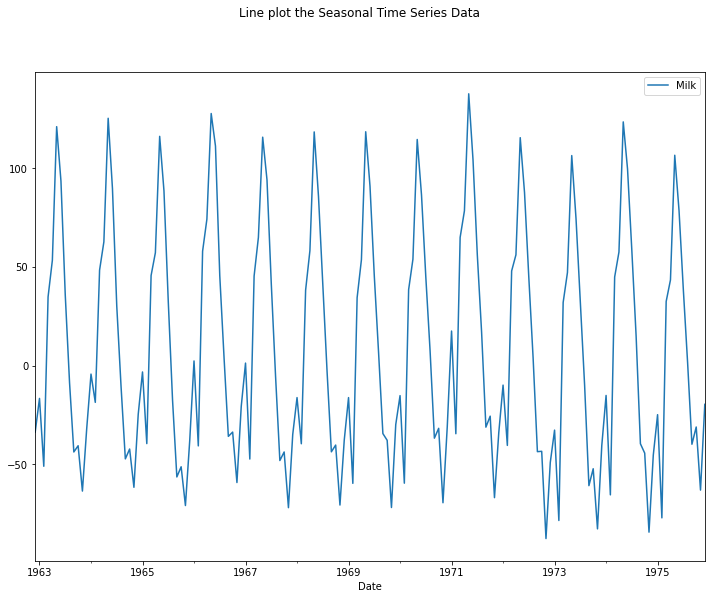

In [115]:
# Create s seaosnal series
N = seasonal_freq
seasonal_series = time_series - time_series.rolling(N).mean()
seasonal_series = seasonal_series.dropna()

# Line plot of the seasonal time series
fig, ax = plt.subplots(figsize=(12, 9))
fig.suptitle('Line plot the Seasonal Time Series Data')
seasonal_series.plot(ax=ax)
plt.show()

In [116]:
result = adfuller(seasonal_series[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -3.643488
p-value: 0.004982
Critical Test Statistics Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578


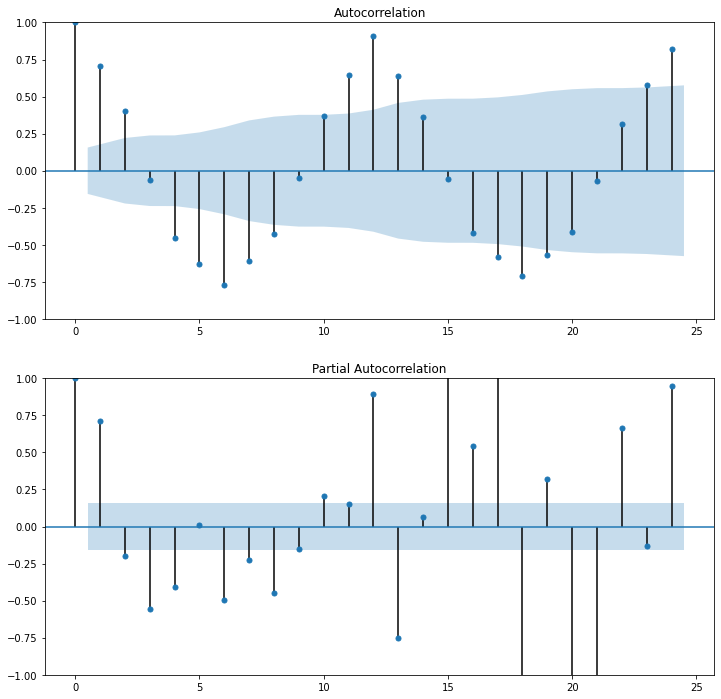

In [117]:
# ACF and PACF plots of the time series data
lag = seasonal_freq * 2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(seasonal_series, lags=lag, ax=ax1)
plot_pacf(seasonal_series, lags=lag, ax=ax2)
plt.show()

#### 3.e) Test for stationarity of seasonal time series data

Occasionally a time series may look non-stationary on the first look. We can make it stationary by differencing the series and using a statistical test to confirm that the differenced result is stationary. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

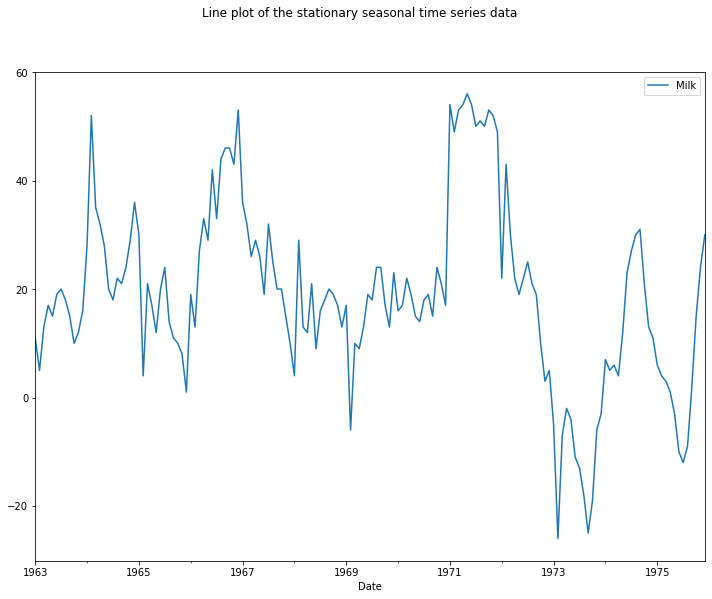

In [118]:
# Create a differenced series
stationary_ss = time_series.diff(seasonal_freq).dropna()

# plot the differenced data
fig, ax = plt.subplots(figsize=(12, 9))
fig.suptitle('Line plot of the stationary seasonal time series data')
stationary_ss.plot(ax=ax)
plt.show()

In [120]:
# Check for stationarity
result = adfuller(stationary_ss[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.335419
p-value: 0.160799
Critical Test Statistics Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578


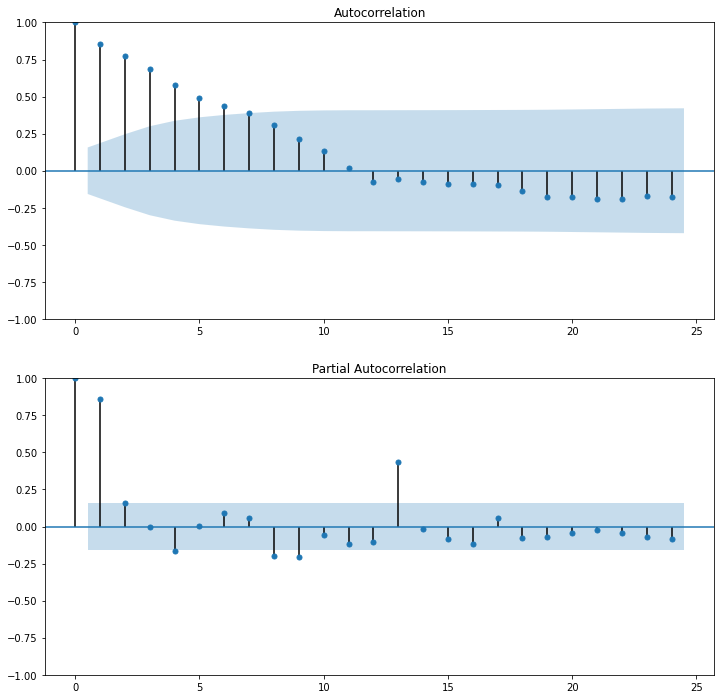

In [121]:
# ACF and PACF plots of the stationary time series
lags = seasonal_freq * 2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(stationary_ss, lags=lags, ax=ax1)
plot_pacf(stationary_ss, lags=lags, ax=ax2)
plt.show()

### Section 4. Fit and Evaluate Model

We will develop a Autoregressive Integrated Moving Average or ARIMA models for the problem. We will first establish a persistent model. Then we will use a grid search approach to look for optimal ARIMA model. This will be followed by investigating the residual errors of the chosen model

* Establish the Persistent Model
* Automatically configure ARIMA model
* Review Residual Errors

#### 4.a.iii) Establish the Persistent Model

We first need to establish a baseline of performance.

The baseline prediction for time series forecasting is called the naive forecast, or persistence. This is where the observations from the previous time steps is used as the prediction for the observation at the nex time step.

In [122]:
X = time_series.values
X = X.astype('float32')
train_pct = 0.80
train_size = int(len(X) * train_pct)
test_size = len(X) - train_size
train_ts, test_ts = X[0:train_size], X[train_size:]

#
history = [x for x in train_ts]
predictions = list()
for i in range(len(test_ts)):
  yhat = history[-1]
  predictions.append(yhat)
  obs = test_ts[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' %(yhat, obs))

#Calculate tperformance
rmse = math.sqrt(mean_squared_error(test_ts, predictions))
print('RMSE for the persistent model is: %.3f' %rmse)


>Predicted=773.000, Expected=883.000
>Predicted=883.000, Expected=898.000
>Predicted=898.000, Expected=957.000
>Predicted=957.000, Expected=924.000
>Predicted=924.000, Expected=881.000
>Predicted=881.000, Expected=837.000
>Predicted=837.000, Expected=784.000
>Predicted=784.000, Expected=791.000
>Predicted=791.000, Expected=760.000
>Predicted=760.000, Expected=802.000
>Predicted=802.000, Expected=828.000
>Predicted=828.000, Expected=778.000
>Predicted=778.000, Expected=889.000
>Predicted=889.000, Expected=902.000
>Predicted=902.000, Expected=969.000
>Predicted=969.000, Expected=947.000
>Predicted=947.000, Expected=908.000
>Predicted=908.000, Expected=867.000
>Predicted=867.000, Expected=815.000
>Predicted=815.000, Expected=812.000
>Predicted=812.000, Expected=773.000
>Predicted=773.000, Expected=813.000
>Predicted=813.000, Expected=834.000
>Predicted=834.000, Expected=782.000
>Predicted=782.000, Expected=892.000
>Predicted=892.000, Expected=903.000
>Predicted=903.000, Expected=966.000
>

#### 4.b) Grid Search for the ARIMA Hyperparameters

We want to find a model that can do better than the persistence model on this dataset. To confirm this analysis, we can grid search a suite of ARIMA hyperparameters.

We will search values of p,d,q for combinations, and find the combination that results in best performance. We will use a grid search to explore all combinations in a subset of integer values.

In [123]:
# Set the initial p, d, q order parameters for non-seasonal ARIMA model
start_p = 0
start_d = None
start_q = 0
max_p = 5
max_d = 2
max_q = 5

In [124]:
# Set the initial P, D, Q order parameters for seasonal ARIMA model
start_P = 0
start_D = None
start_Q = 0
max_P = 2
max_D = 1
max_Q = 2

In [125]:
# Testing the timeseries data for suggestions on the diffrencing term
start_d = pm.arima.ndiffs(train_ts)
print('The suggested non-seasonal difference term is:', start_d)
if(seasonal_freq!=0):
  start_D = pm.arima.nsdiffs(train_ts, m = seasonal_freq)
  print('The suggested seasonal diffrencing term is:', start_D)

The suggested non-seasonal difference term is: 1
The suggested seasonal diffrencing term is: 1


In [126]:
print('The initial non-seasonal parameters are: p =', start_p, '| d =', start_d, '| q =', start_q)
print('The maximum non-seasonal parameters are: max_p =', max_p, '| max_d =', max_d, '| max_q =', max_q)
print('The initial seasonal parameters are: P =', start_P, '| D =', start_D, '| Q =', start_Q, '| m =', seasonal_freq)
print('The maximum seasonal parameters are: max_P =', max_P, '| max_D =', max_D, '| max_Q =', max_Q)

The initial non-seasonal parameters are: p = 0 | d = 1 | q = 0
The maximum non-seasonal parameters are: max_p = 5 | max_d = 2 | max_q = 5
The initial seasonal parameters are: P = 0 | D = 1 | Q = 0 | m = 12
The maximum seasonal parameters are: max_P = 2 | max_D = 1 | max_Q = 2


In [127]:
# Do an automated stepwise search of ARIMA parameters
if(seasonal_freq == 0):
  stepwise_results = pm.auto_arima(train_ts, seasonal= False, stepwise=True, trace = True, suppress_warnings = True, random_state = seedNum)
else:
  stepwise_results = pm.auto_arima(train_ts, seasonal = True, m = seasonal_freq, stepwise = True, trace = True, suppress_warnings = True, random_state = seedNum)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=852.744, Time=2.56 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1004.783, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=869.223, Time=0.83 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=907.132, Time=0.97 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1156.184, Time=0.03 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=850.823, Time=1.83 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=885.787, Time=0.66 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=852.714, Time=4.22 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=864.028, Time=1.65 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=851.685, Time=8.57 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=850.088, Time=1.46 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=885.394, Time=0.58 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=852.017, Time=1.72 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=851.988, Time=2.85 sec
 ARIMA(1,0,2)(1,1,0)[12] interc

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  134
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -419.580
Date:                              Thu, 07 Apr 2022   AIC                            849.160
Time:                                      01:06:57   BIC                            863.180
Sample:                                           0   HQIC                           854.855
                                              - 134                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.9672      1.492      1.988      0.047       0.042       5.892
ar.L1          0.65

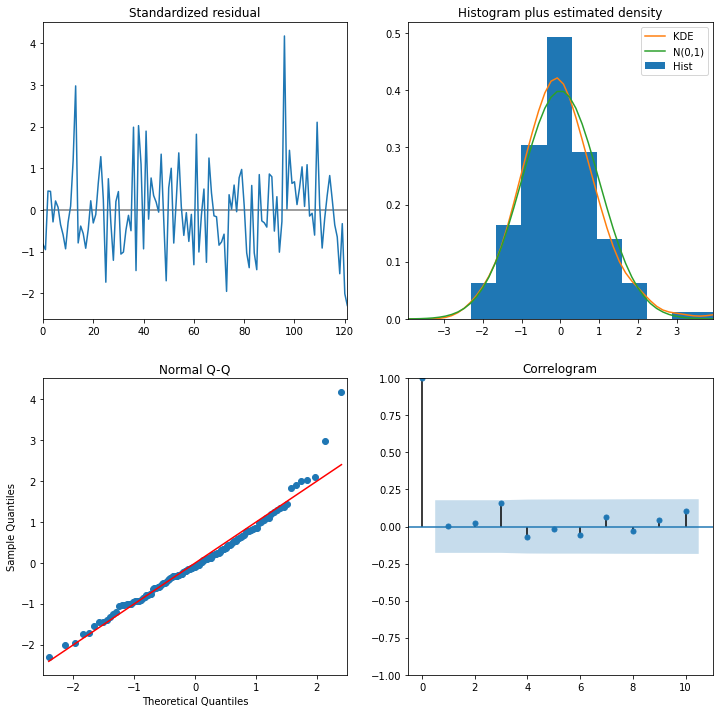

In [128]:
# Summarize residual errors for automated grid search ARIMA model
print(stepwise_results.summary())
stepwise_results.plot_diagnostics(figsize=(12,12))
plt.show()

In [129]:
# Do an automated random search from ARIMA parameters
n_fits = int(max_p * max_d * max_q * max_P * max_D * max_Q * 0.30)
if (seasonal_freq == 0):
    randgrid_results = pm.auto_arima(train_ts, start_p = start_p, d = start_d, start_q = start_q, max_p = max_p, max_d = max_d, max_q = max_q,
                                     seasonal = False, stepwise = False, random = True, n_fits = n_fits, max_order = None,
                                     trace = True, suppress_warnings = True, random_state = seedNum)
else:
    randgrid_results = pm.auto_arima(train_ts, start_p = start_p, d = start_d, start_q = start_q, max_p = max_p, max_d = max_d, max_q = max_q,
                                     seasonal = True, m = seasonal_freq, start_P = start_P, D = start_D, start_Q = start_Q, max_P = max_P, max_D = max_D, max_Q = max_Q,
                                     stepwise = False, random = True, n_fits = n_fits, max_order = None,
                                     trace = True, suppress_warnings = True, random_state = seedNum)

 ARIMA(3,1,4)(1,1,1)[12]             : AIC=inf, Time=5.32 sec
 ARIMA(5,1,0)(2,1,1)[12]             : AIC=851.560, Time=2.74 sec
 ARIMA(5,1,5)(2,1,0)[12]             : AIC=inf, Time=7.32 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=845.498, Time=0.79 sec
 ARIMA(2,1,3)(1,1,1)[12]             : AIC=847.712, Time=3.99 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=877.108, Time=0.07 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=843.536, Time=0.32 sec
 ARIMA(3,1,5)(2,1,2)[12]             : AIC=inf, Time=12.44 sec
 ARIMA(1,1,4)(0,1,1)[12]             : AIC=847.275, Time=0.91 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=845.507, Time=0.55 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=inf, Time=4.24 sec
 ARIMA(1,1,5)(2,1,2)[12]             : AIC=inf, Time=11.39 sec
 ARIMA(3,1,3)(0,1,1)[12]             : AIC=847.730, Time=3.94 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=inf, Time=10.35 sec
 ARIMA(1,1,3)(0,1,2)[12]             : AIC=inf, Time=5.99 sec
 ARIMA(1,1,5)(1,1,1)[12]           

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  134
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -418.768
Date:                              Thu, 07 Apr 2022   AIC                            843.536
Time:                                      01:19:28   BIC                            851.923
Sample:                                           0   HQIC                           846.942
                                              - 134                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2749      0.091     -3.015      0.003      -0.454      -0.096
ma.S.L12      -0.62

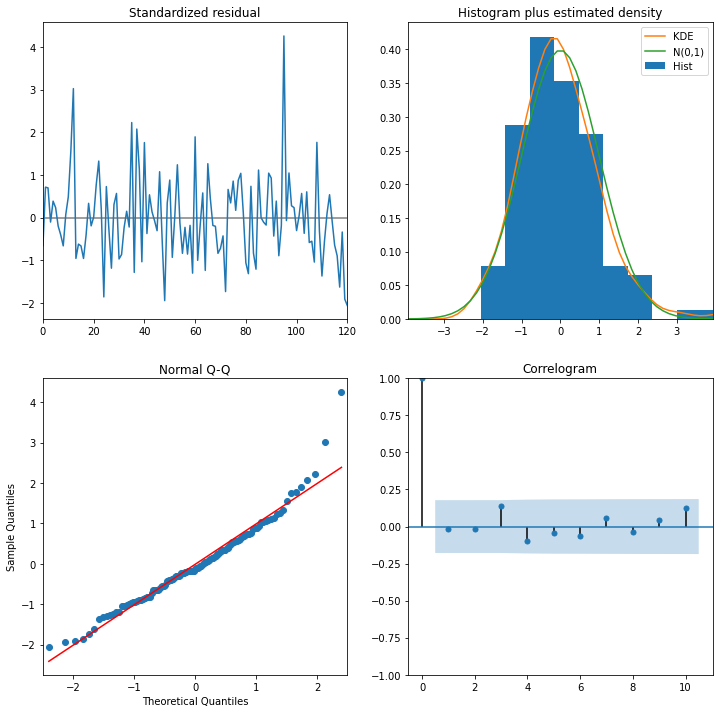

In [130]:
# Summarize the residual errors for the automated grid search  ARIMA model
print(randgrid_results.summary())
randgrid_results.plot_diagnostics(figsize=(12,12))
plt.show()

In [132]:
# Do an automated grid search of ARIMA parameters
if (seasonal_freq == 0):
    autogrid_results = pm.auto_arima(train_ts, start_p = start_p, d = start_d, start_q = start_q, max_p = max_p, max_d = max_d, max_q = max_q,
                                     seasonal = False, stepwise = False, max_order = None, trace = True, suppress_warnings = True, random_state = seedNum)
else:
    autogrid_results = pm.auto_arima(train_ts, start_p = start_p, d = start_d, start_q = start_q, max_p = max_p, max_d = max_d, max_q = max_q,
                                     seasonal = True, m = seasonal_freq, start_P = start_P, D = start_D, start_Q = start_Q, max_P = max_P, max_D = max_D, max_Q = max_Q,
                                     stepwise = False, max_order = None, trace = True, suppress_warnings = True, random_state = seedNum)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=886.286, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=850.915, Time=0.18 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=852.914, Time=0.77 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=865.948, Time=0.17 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=852.914, Time=0.48 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=3.81 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=859.108, Time=0.48 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=854.066, Time=1.18 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=851.809, Time=3.28 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=877.128, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=843.667, Time=0.45 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=845.654, Time=1.08 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=857.298, Time=0.28 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=845.657, Time=0.58 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=4.95 sec
 ARIMA(0,1,1)(2,1,

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  134
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -418.768
Date:                              Thu, 07 Apr 2022   AIC                            843.536
Time:                                      01:43:36   BIC                            851.923
Sample:                                           0   HQIC                           846.942
                                              - 134                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2749      0.091     -3.015      0.003      -0.454      -0.096
ma.S.L12      -0.62

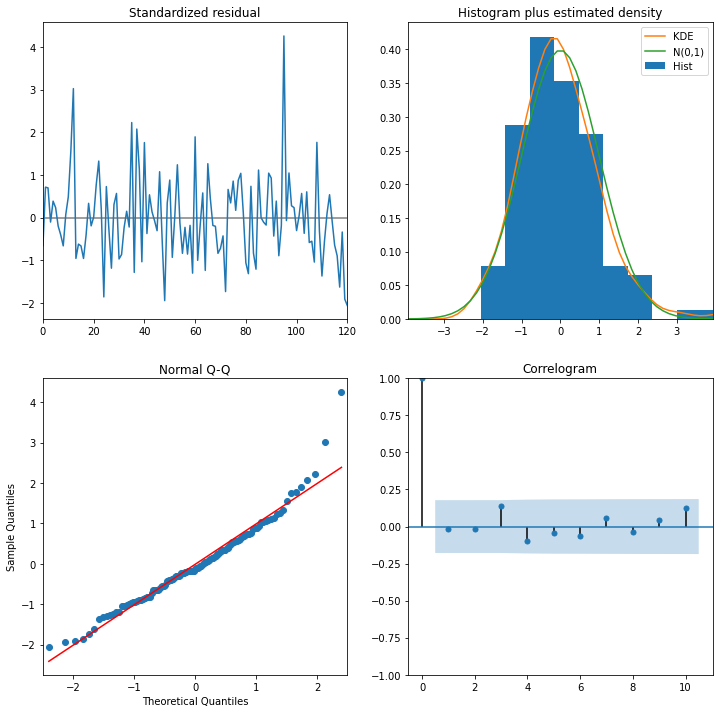

In [133]:
# Summarize residual errors for the automated grid search ARIMA model
print(autogrid_results.summary())
autogrid_results.plot_diagnostics(figsize=(12,12))
plt.show()

#### 4.c) Evaluate the Residual Errors

A good final check of the model is to review residual forecast errors. Ideally, the distribution of residual errors should be Gausian with zero mean.

In [134]:
# Set the ARIMA order parameter for validation and forecasting
final_ns_order = autogrid_results.order
final_ss_order = autogrid_results.seasonal_order

print("Final Non-Seasonal order:", final_ns_order, 'Final seasonal order:', final_ss_order)

Final Non-Seasonal order: (1, 1, 0) Final seasonal order: (0, 1, 1, 12)


                                      SARIMAX Results                                       
Dep. Variable:                                 Milk   No. Observations:                  168
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -530.104
Date:                              Thu, 07 Apr 2022   AIC                           1066.207
Time:                                      01:43:54   BIC                           1075.337
Sample:                                  01-01-1962   HQIC                          1069.916
                                       - 12-01-1975                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2253      0.077     -2.925      0.003      -0.376      -0.074
ma.S.L12      -0.61

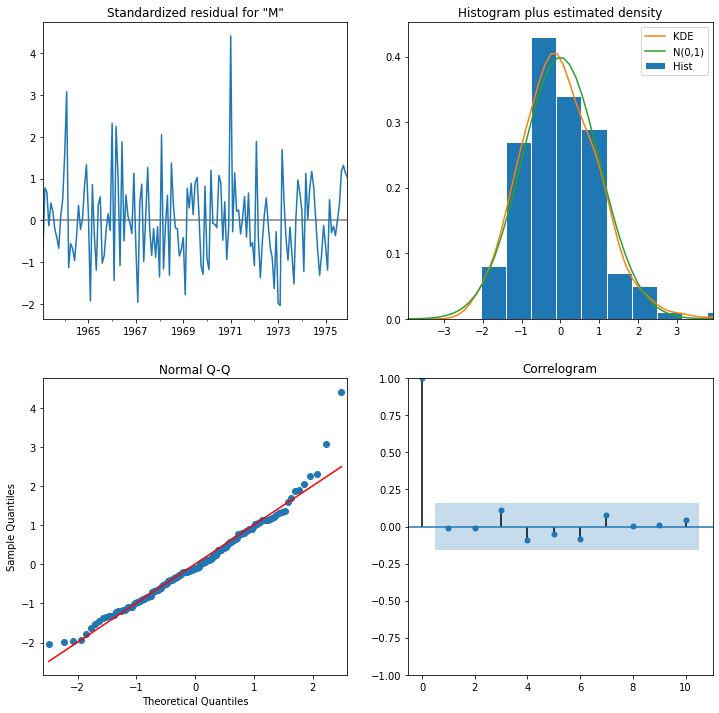

In [135]:
# Summarize residual errors for the final ARIMA model
final_model = SARIMAX(time_series, order=final_ns_order, seasonal_order=final_ss_order)
final_results = final_model.fit(disp=False)
print(final_results.summary())
final_results.plot_diagnostics(figsize=(12,12))
plt.show()

### Section 5. Finalize Model

After models have been developed and final model selected, it must be validated and finalized. Validation is an optional part of the process, but one that provides a `last check` to ensure we have not fooled or lied to ourselves.

####5.a) Validation via In-sampel Data

In [136]:
forecast = final_results.get_prediction(start= -test_size)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

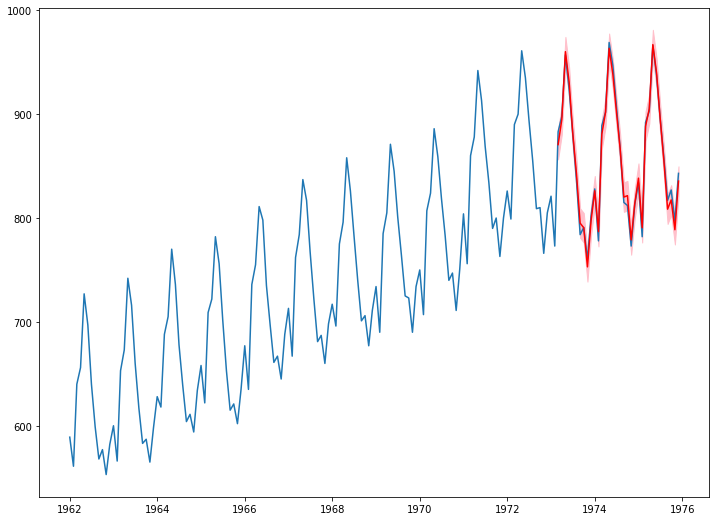

In [139]:
plt.figure(figsize=(12,9))
plt.plot(time_series.index, time_series[target_col], label='observed')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')
plt.fill_between(confidence_intervals.index, confidence_intervals[lower_bound], confidence_intervals[upper_bound], color='pink')
plt.show()

In [140]:
# Evaluate RMSE for the validation data
y = time_series[-test_size:]
predictions = mean_forecast.values
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE from the validation data is: %.3f' % rmse)

RMSE from the validation data is: 6.189


####5.b) Forecasting Out-of-Sample Data

In [141]:
forecast = final_results.get_forecast(steps = test_size)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
print("The forecasted values are:\n\n", mean_forecast)

The forecasted values are:

 1976-01-01     865.349739
1976-02-01     818.387706
1976-03-01     925.019489
1976-04-01     938.096591
1976-05-01    1001.238546
1976-06-01     973.830260
1976-07-01     932.477681
1976-08-01     892.889158
1976-09-01     846.994443
1976-10-01     852.166204
1976-11-01     818.130555
1976-12-01     860.408590
1977-01-01     883.596821
1977-02-01     836.445891
1977-03-01     943.120229
1977-04-01     956.187743
1977-05-01    1019.331859
1977-06-01     991.923085
1977-07-01     950.570617
1977-08-01     910.982068
1977-09-01     865.087359
1977-10-01     870.259119
1977-11-01     836.223470
1977-12-01     878.501505
1978-01-01     901.689736
1978-02-01     854.538806
1978-03-01     961.213144
1978-04-01     974.280658
1978-05-01    1037.424774
1978-06-01    1010.016000
1978-07-01     968.663532
1978-08-01     929.074983
1978-09-01     883.180274
1978-10-01     888.352034
Freq: MS, Name: predicted_mean, dtype: float64


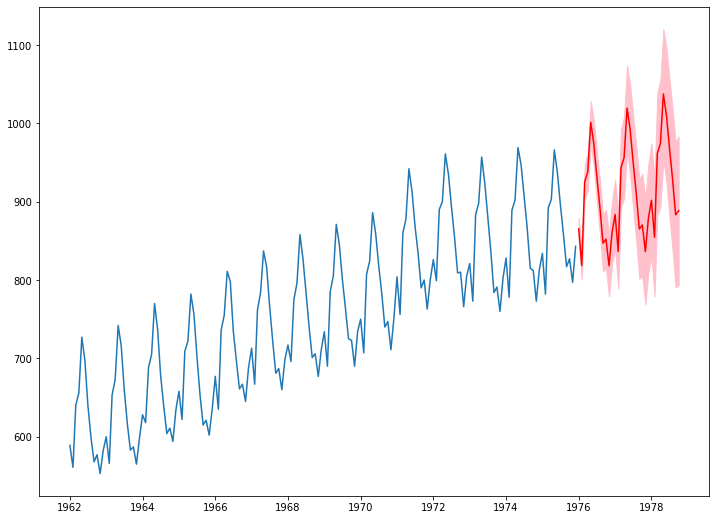

In [142]:
plt.figure(figsize=(12,9))
plt.plot(time_series.index, time_series[target_col], label='observed')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')
plt.fill_between(confidence_intervals.index, confidence_intervals[lower_bound], confidence_intervals[upper_bound], color='pink')
plt.show()

In [143]:
print("Total time for the script:", (datetime.now() - startTimeScript))

Total time for the script: 1:30:22.059927
